# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression



# Hier fehlen noch die Prozessraten für rmass und rvol!



In [1]:
version  = '08'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="rimedice"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 265513)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 16:33:46 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_rimedice.values
    n_s  = xr.open_dataset(fname).n_rimedice.values
    r_s  = xr.open_dataset(fname).rime_rimedice.values
    v_s  = xr.open_dataset(fname).rvol_rimedice.values
    # process rates
    self_num   = xr.open_dataset(fname).self_rimedice_num.values
    self_mass  = xr.open_dataset(fname).self_rimedice_mass.values
    self_rvol  = xr.open_dataset(fname).self_rimedice_rvol.values
    self_rmass = xr.open_dataset(fname).self_rimedice_rmass.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    p_min = 1e-15
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    self_num  = np.log(self_num,  where=self_num>p_min, out=np.nan*self_num)    
    self_mass = np.log(self_mass, where=self_num>p_min, out=np.nan*self_mass)    
    self_rmass = np.log(self_rmass, where=self_num>p_min, out=np.nan*self_rmass)    
    self_rvol = np.log(self_rvol, where=self_num>p_min, out=np.nan*self_rvol)    
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, temp, rho, self_num, self_mass, self_rmass, self_rvol ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'temp', 'rho', 'self_num', 'self_mass', 'self_rmass', 'self_rvol' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s           n_s           r_s           v_s          temp  \
count  21608.000000  21608.000000  21608.000000  21608.000000  21608.000000   
mean      -8.278021     11.211770     -9.270876    -14.507946    258.390778   
std        0.943165      1.310891      1.246305      1.283410      6.848120   
min      -18.505869      3.098695    -18.823116    -24.709204    246.369995   
25%       -8.923996     10.349094    -10.145967    -15.408104    253.490005   
50%       -8.286280     11.052595     -9.223015    -14.465627    256.839996   
75%       -7.644045     11.908694     -8.331502    -13.545217    261.540009   
max       -5.269536     16.136034     -5.991785    -11.166290    274.320007   

                rho      self_num     self_mass    self_rmass     self_rvol  
count  21608.000000  21608.000000  21608.000000  21608.000000  21608.000000  
mean       0.907382      1.638435    -16.986771    -17.944988    -23.176275  
std        0.108842      1.434843      1.363438      1.760466      1.782493  
min        0.716000      0.004550    -22.000086    -26.742767    -31.853756  
25%        0.829000      0.587787    -17.927024    -19.053893    -24.306530  
50%        0.882000      1.223776    -17.031734    -17.803565    -23.037086  
75%        0.955000      2.251292    -16.128520    -16.752399    -21.972347  
max        1.260000      8.519822    -11.125788    -12.295638    -17.618652

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s        temp    rho  self_num  \
429  -9.523901  8.671818 -10.441102 -15.883815  273.320007  1.085  0.145182   
434  -9.533028  8.630522 -10.671746 -16.117395  273.440002  1.087  0.247836   
435  -9.538789  8.615517 -10.740044 -16.186695  273.470001  1.088  0.661398   
9103 -9.605059  8.579153  -9.934483 -15.901534  273.390015  1.058  0.223144   
9110 -9.766913  8.051883 -10.510677 -16.477818  273.670013  1.062  0.117783   

      self_mass  self_rmass  self_rvol  
429  -17.272589  -18.118570 -23.534405  
434  -17.120573  -18.285740 -23.699522  
435  -16.371510  -17.150112 -22.600786  
9103 -16.935089  -17.367031 -23.067850  
9110 -16.796721  -17.904121 -23.674095

In [11]:
dataset_train.describe()

q_s           n_s           r_s           v_s          temp  \
count  15077.000000  15077.000000  15077.000000  15077.000000  15077.000000   
mean      -8.271073     11.219510     -9.261653    -14.498519    258.389801   
std        0.949880      1.316723      1.250820      1.288276      6.849164   
min      -18.505869      3.098695    -18.823116    -24.709204    246.369995   
25%       -8.923059     10.347629    -10.136479    -15.402014    253.490005   
50%       -8.284971     11.062348     -9.219169    -14.461545    256.820007   
75%       -7.632042     11.926888     -8.320271    -13.531837    261.570007   
max       -5.299738     16.097975     -6.025973    -11.201185    274.320007   

                rho      self_num     self_mass    self_rmass     self_rvol  
count  15077.000000  15077.000000  15077.000000  15077.000000  15077.000000  
mean       0.907418      1.644426    -16.981480    -17.936039    -23.167088  
std        0.108769      1.445442      1.370071      1.764059      1.786182  
min        0.716000      0.004550    -22.000086    -26.742767    -31.853756  
25%        0.829000      0.559616    -17.928837    -19.052263    -24.305294  
50%        0.882000      1.223776    -17.029520    -17.799093    -23.034002  
75%        0.955000      2.261763    -16.115688    -16.743021    -21.955343  
max        1.260000      8.517145    -11.128582    -12.295638    -17.618652

In [12]:
dataset_test.describe()

q_s          n_s          r_s          v_s         temp  \
count  3258.000000  3258.000000  3258.000000  3258.000000  3258.000000   
mean     -8.286223    11.214001    -9.283010   -14.520049   258.375549   
std       0.909939     1.295909     1.210437     1.245914     6.797129   
min     -12.002365     5.952022   -14.651328   -19.718819   246.529999   
25%      -8.901919    10.379139   -10.125731   -15.389750   253.500000   
50%      -8.284971    11.044952    -9.218690   -14.468121   256.985001   
75%      -7.683437    11.884403    -8.370272   -13.603189   261.465004   
max      -5.269536    16.136034    -6.188210   -11.386381   274.200012   

               rho     self_num    self_mass   self_rmass    self_rvol  
count  3258.000000  3258.000000  3258.000000  3258.000000  3258.000000  
mean      0.906737     1.626768   -17.014277   -17.980810   -23.212379  
std       0.108001     1.416594     1.345878     1.729348     1.751380  
min       0.722000     0.024693   -21.208738   -24.789139   -30.132763  
25%       0.829000     0.587787   -17.905773   -19.036522   -24.290210  
50%       0.882000     1.252763   -17.071018   -17.841150   -23.068177  
75%       0.955000     2.240710   -16.171341   -16.848899   -22.055660  
max       1.243000     8.519822   -11.125788   -12.344955   -17.661240

In [13]:
dataset_val.describe()

q_s          n_s          r_s          v_s         temp  \
count  3273.000000  3273.000000  3273.000000  3273.000000  3273.000000   
mean     -8.301854    11.173897    -9.301288   -14.539324   258.410522   
std       0.944441     1.298478     1.260373     1.297441     6.895762   
min     -12.924169     6.731161   -15.251205   -20.583765   246.570007   
25%      -8.945671    10.337379   -10.205350   -15.463949   253.470001   
50%      -8.294209    11.011357    -9.260035   -14.489639   256.799988   
75%      -7.654366    11.834066    -8.345006   -13.562963   261.459991   
max      -5.326614    16.019291    -5.991785   -11.166290   274.279999   

               rho     self_num    self_mass   self_rmass    self_rvol  
count  3273.000000  3273.000000  3273.000000  3273.000000  3273.000000  
mean      0.907861     1.622447   -16.983740   -17.950544   -23.182646  
std       0.110036     1.403788     1.350199     1.774600     1.796186  
min       0.717000     0.010109   -21.542509   -25.184561   -30.327963  
25%       0.829000     0.615186   -17.943075   -19.083673   -24.329290  
50%       0.880000     1.223776   -17.006927   -17.787884   -23.029848  
75%       0.956000     2.174752   -16.139530   -16.733980   -21.954897  
max       1.240000     8.066898   -12.030591   -12.655201   -17.944342

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -15 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s           n_s           r_s           v_s          temp  \
count  13759.000000  13759.000000  13759.000000  13759.000000  13759.000000   
mean      -8.193095     11.380721     -9.168167    -14.386726    256.946808   
std        0.911049      1.210425      1.216841      1.239199      5.249923   
min      -12.744132      7.549609    -13.970797    -19.129084    246.369995   
25%       -8.827905     10.498195    -10.017721    -15.252951    253.139999   
50%       -8.232691     11.168066     -9.142028    -14.370584    256.260010   
75%       -7.585462     11.992910     -8.258605    -13.465030    259.950012   
max       -5.299738     16.097975     -6.025973    -11.201185    273.000000   

                rho      self_num     self_mass    self_rmass     self_rvol  
count  13759.000000  13759.000000  13759.000000  13759.000000  13759.000000  
mean       0.884403      1.695976    -17.018963    -17.958218    -23.173798  
std        0.082107      1.458400      1.367236      1.779186      1.804852  
min        0.716000      0.010881    -22.000086    -26.742767    -31.853756  
25%        0.824000      0.587787    -17.975079    -19.097167    -24.333010  
50%        0.872000      1.280934    -17.076052    -17.831522    -23.047249  
75%        0.931000      2.360854    -16.160887    -16.745637    -21.937400  
max        1.200000      8.169846    -11.872393    -12.505439    -17.654455

In [17]:
dataset_test.describe()

q_s          n_s          r_s          v_s         temp  \
count  2971.000000  2971.000000  2971.000000  2971.000000  2971.000000   
mean     -8.212569    11.374629    -9.197225   -14.417933   256.918182   
std       0.875535     1.187557     1.184233     1.207751     5.152002   
min     -12.002365     7.873979   -14.651328   -19.718819   246.529999   
25%      -8.801151    10.527512   -10.012088   -15.249568   253.205002   
50%      -8.237556    11.164984    -9.155947   -14.367679   256.239990   
75%      -7.644959    11.958090    -8.325706   -13.533872   259.875000   
max      -5.269536    16.136034    -6.188210   -11.386381   273.000000   

               rho     self_num    self_mass   self_rmass    self_rvol  
count  2971.000000  2971.000000  2971.000000  2971.000000  2971.000000  
mean      0.883303     1.677698   -17.055410   -18.009037   -23.227068  
std       0.080013     1.430290     1.339705     1.746509     1.773153  
min       0.722000     0.024693   -21.208738   -24.789139   -30.132763  
25%       0.824000     0.608383   -17.932936   -19.090106   -24.325321  
50%       0.873000     1.308333   -17.122252   -17.882568   -23.086058  
75%       0.930000     2.292535   -16.218900   -16.860175   -22.053674  
max       1.202000     7.987525   -11.901489   -12.542439   -17.826172

### Pairplot

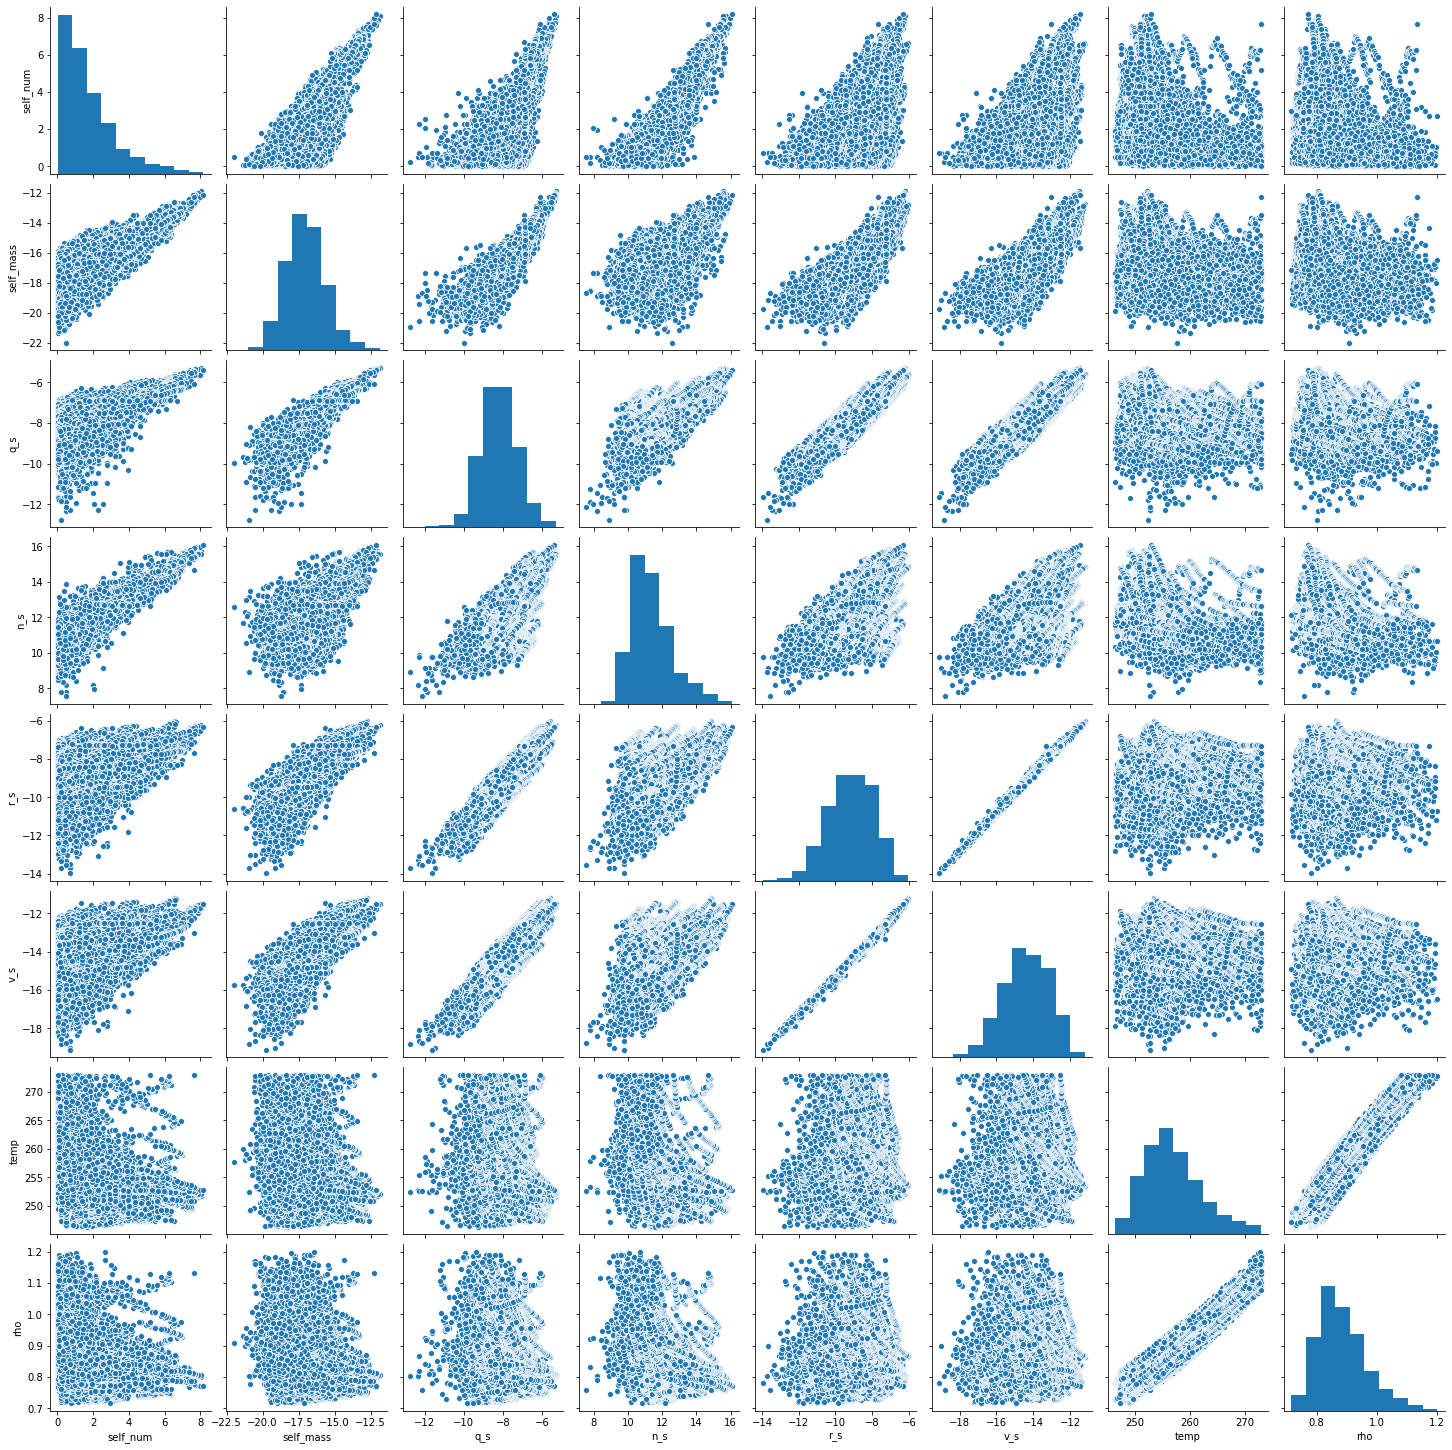

In [18]:
sns.pairplot(dataset_train[["self_num","self_mass",'q_s','n_s','r_s','v_s',"temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho'], axis=1)
train_dataset2 = train_dataset2.drop(['rho'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho'], axis=1)
test_dataset2 = test_dataset2.drop(['rho'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho'], axis=1)
val_dataset2 = val_dataset2.drop(['rho'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self_num")
train_stats1.pop("self_mass")
train_stats1.pop("self_rmass")
train_stats1.pop("self_rvol")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
q_s  13759.0  -8.193095  0.911049 -12.744132  -8.827905  -8.232691  -7.585462   
n_s  13759.0  11.380721  1.210425   7.549609  10.498195  11.168066  11.992910   
r_s  13759.0  -9.168167  1.216841 -13.970797 -10.017721  -9.142028  -8.258605   
v_s  13759.0 -14.386726  1.239199 -19.129084 -15.252951 -14.370584 -13.465030   

           max  
q_s  -5.299738  
n_s  16.097975  
r_s  -6.025973  
v_s -11.201185

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self_num")
train_stats2.pop("self_mass")
train_stats2.pop("self_rmass")
train_stats2.pop("self_rvol")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean       std         min         25%         50%  \
q_s   13759.0   -8.193095  0.911049  -12.744132   -8.827905   -8.232691   
n_s   13759.0   11.380721  1.210425    7.549609   10.498195   11.168066   
r_s   13759.0   -9.168167  1.216841  -13.970797  -10.017721   -9.142028   
v_s   13759.0  -14.386726  1.239199  -19.129084  -15.252951  -14.370584   
temp  13759.0  256.946808  5.249923  246.369995  253.139999  256.260010   

             75%         max  
q_s    -7.585462   -5.299738  
n_s    11.992910   16.097975  
r_s    -8.258605   -6.025973  
v_s   -13.465030  -11.201185  
temp  259.950012  273.000000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self_num")
train_stats3.pop("self_mass")
train_stats3.pop("self_rmass")
train_stats3.pop("self_rvol")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std         min         25%         50%  \
q_s   13759.0   -8.193095  0.911049  -12.744132   -8.827905   -8.232691   
n_s   13759.0   11.380721  1.210425    7.549609   10.498195   11.168066   
r_s   13759.0   -9.168167  1.216841  -13.970797  -10.017721   -9.142028   
v_s   13759.0  -14.386726  1.239199  -19.129084  -15.252951  -14.370584   
temp  13759.0  256.946808  5.249923  246.369995  253.139999  256.260010   
rho   13759.0    0.884403  0.082107    0.716000    0.824000    0.872000   

             75%         max  
q_s    -7.585462   -5.299738  
n_s    11.992910   16.097975  
r_s    -8.258605   -6.025973  
v_s   -13.465030  -11.201185  
temp  259.950012  273.000000  
rho     0.931000    1.200000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = ['self_num', 'self_mass', 'self_rmass', 'self_rvol']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

self_num     self_mass    self_rmass     self_rvol
count  13759.000000  13759.000000  13759.000000  13759.000000
mean       1.695976    -17.018963    -17.958218    -23.173798
std        1.458400      1.367236      1.779186      1.804852
min        0.010881    -22.000086    -26.742767    -31.853756
25%        0.587787    -17.975079    -19.097167    -24.333010
50%        1.280934    -17.076052    -17.831522    -23.047249
75%        2.360854    -16.160887    -16.745637    -21.937400
max        8.169846    -11.872393    -12.505439    -17.654455

In [32]:
train_dataset1.describe()

q_s           n_s           r_s           v_s
count  13759.000000  13759.000000  13759.000000  13759.000000
mean      -8.193095     11.380721     -9.168167    -14.386726
std        0.911049      1.210425      1.216841      1.239199
min      -12.744132      7.549609    -13.970797    -19.129084
25%       -8.827905     10.498195    -10.017721    -15.252951
50%       -8.232691     11.168066     -9.142028    -14.370584
75%       -7.585462     11.992910     -8.258605    -13.465030
max       -5.299738     16.097975     -6.025973    -11.201185

In [33]:
train_dataset2.describe()

q_s           n_s           r_s           v_s          temp
count  13759.000000  13759.000000  13759.000000  13759.000000  13759.000000
mean      -8.193095     11.380721     -9.168167    -14.386726    256.946808
std        0.911049      1.210425      1.216841      1.239199      5.249923
min      -12.744132      7.549609    -13.970797    -19.129084    246.369995
25%       -8.827905     10.498195    -10.017721    -15.252951    253.139999
50%       -8.232691     11.168066     -9.142028    -14.370584    256.260010
75%       -7.585462     11.992910     -8.258605    -13.465030    259.950012
max       -5.299738     16.097975     -6.025973    -11.201185    273.000000

In [34]:
train_dataset3.describe()

q_s           n_s           r_s           v_s          temp  \
count  13759.000000  13759.000000  13759.000000  13759.000000  13759.000000   
mean      -8.193095     11.380721     -9.168167    -14.386726    256.946808   
std        0.911049      1.210425      1.216841      1.239199      5.249923   
min      -12.744132      7.549609    -13.970797    -19.129084    246.369995   
25%       -8.827905     10.498195    -10.017721    -15.252951    253.139999   
50%       -8.232691     11.168066     -9.142028    -14.370584    256.260010   
75%       -7.585462     11.992910     -8.258605    -13.465030    259.950012   
max       -5.299738     16.097975     -6.025973    -11.201185    273.000000   

                rho  
count  13759.000000  
mean       0.884403  
std        0.082107  
min        0.716000  
25%        0.824000  
50%        0.872000  
75%        0.931000  
max        1.200000

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  13759.0  2.128342e-07  1.0 -4.995379 -0.696790 -0.043462  0.666960   
n_s  13759.0  3.450392e-07  1.0 -3.165096 -0.729105 -0.175686  0.505764   
r_s  13759.0  5.230180e-07  1.0 -3.946801 -0.698163  0.021481  0.747478   
v_s  13759.0  3.117175e-07  1.0 -3.826954 -0.699020  0.013026  0.743784   

          max  
q_s  3.175851  
n_s  3.897188  
r_s  2.582255  
v_s  2.570646

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s   13759.0  2.128342e-07  1.0 -4.995379 -0.696790 -0.043462  0.666960   
n_s   13759.0  3.450392e-07  1.0 -3.165096 -0.729105 -0.175686  0.505764   
r_s   13759.0  5.230180e-07  1.0 -3.946801 -0.698163  0.021481  0.747478   
v_s   13759.0  3.117175e-07  1.0 -3.826954 -0.699020  0.013026  0.743784   
temp  13759.0  1.685711e-06  1.0 -2.014660 -0.725117 -0.130821  0.572047   

           max  
q_s   3.175851  
n_s   3.897188  
r_s   2.582255  
v_s   2.570646  
temp  3.057796

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s   13759.0  2.128342e-07  1.0 -4.995379 -0.696790 -0.043462  0.666960   
n_s   13759.0  3.450392e-07  1.0 -3.165096 -0.729105 -0.175686  0.505764   
r_s   13759.0  5.230180e-07  1.0 -3.946801 -0.698163  0.021481  0.747478   
v_s   13759.0  3.117175e-07  1.0 -3.826954 -0.699020  0.013026  0.743784   
temp  13759.0  1.685711e-06  1.0 -2.014660 -0.725117 -0.130821  0.572047   
rho   13759.0  3.851035e-07  1.0 -2.051024 -0.735664 -0.151060  0.567516   

           max  
q_s   3.175851  
n_s   3.897188  
r_s   2.582255  
v_s   2.570646  
temp  3.057796  
rho   3.843738

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
self_num    13759.0   1.695976  1.458400   0.010881   0.587787   1.280934   
self_mass   13759.0 -17.018963  1.367236 -22.000086 -17.975079 -17.076052   
self_rmass  13759.0 -17.958218  1.779186 -26.742767 -19.097167 -17.831522   
self_rvol   13759.0 -23.173798  1.804852 -31.853756 -24.333010 -23.047249   

                  75%        max  
self_num     2.360854   8.169846  
self_mass  -16.160887 -11.872393  
self_rmass -16.745637 -12.505439  
self_rvol  -21.937400 -17.654455

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(4)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(4,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 692
Trainable params: 692
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.6776582 , -0.66987884,  0.00244984,  0.36168295],
       [-0.68017006, -0.6701454 ,  0.00348744,  0.36326665],
       [-0.686372  , -0.67084944,  0.00582924,  0.3668199 ],
       [-0.68807316, -0.6710738 ,  0.00640818,  0.36775026],
       [-0.6923512 , -0.6716959 ,  0.0077689 ,  0.3698817 ],
       [-0.6945528 , -0.6720738 ,  0.00838941,  0.37091762],
       [-0.6962143 , -0.67240036,  0.00881249,  0.37163636],
       [-0.6974124 , -0.6726775 ,  0.0090687 ,  0.37213254],
       [-0.6986736 , -0.6730292 ,  0.00927848,  0.3725828 ],
       [-0.6993158 , -0.67323923,  0.00935033,  0.37280595]],
      dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "sigm"
model1 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.7808,  mae:0.6814,  mse:0.7808,  val_loss:0.4397,  val_mae:0.5045,  val_mse:0.4397,  
....................................................................

Text(0, 0.5, 'MAE')

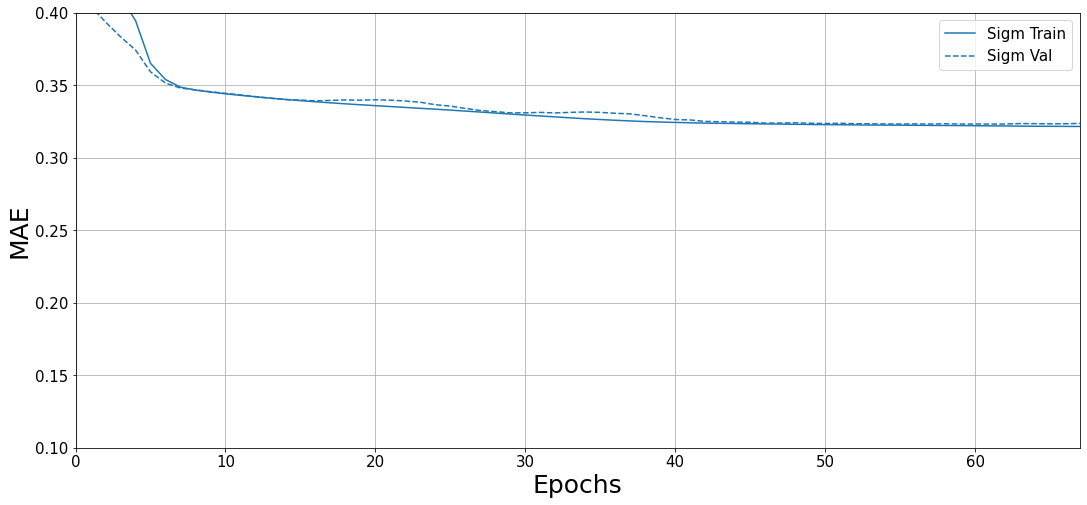

In [47]:
histories['sigm'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.4])
plt.ylabel('MAE')

In [48]:
activ = "ReLU"
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3539,  mae:0.4294,  mse:0.3539,  val_loss:0.2061,  val_mae:0.3423,  val_mse:0.2061,  
.............................................................................................

Text(0, 0.5, 'MAE')

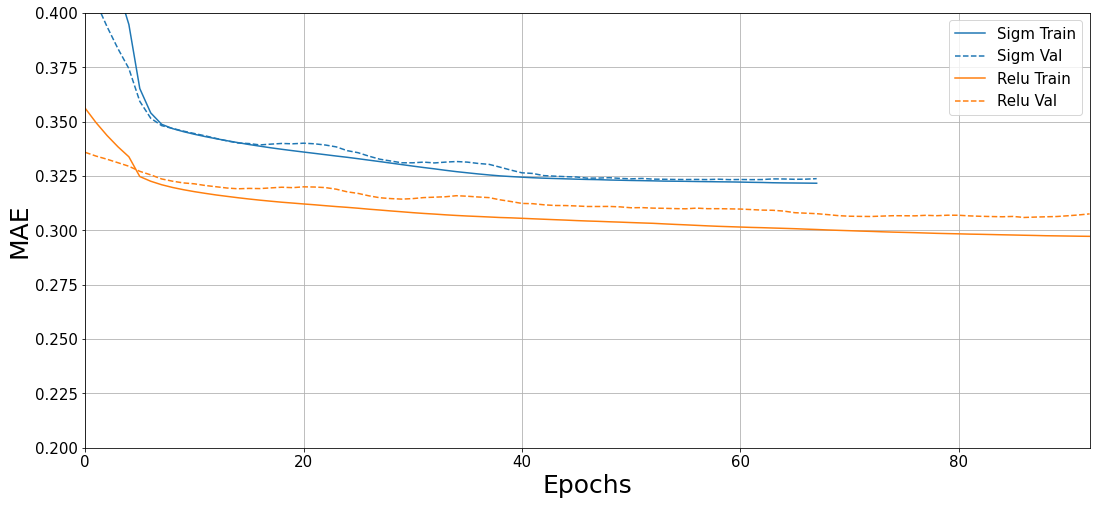

In [50]:
histories['ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.2, 0.4])
plt.ylabel('MAE')

In [51]:
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3478,  mae:0.4303,  mse:0.3478,  val_loss:0.2134,  val_mae:0.3495,  val_mse:0.2134,  
..........................................................................

Text(0, 0.5, 'MAE')

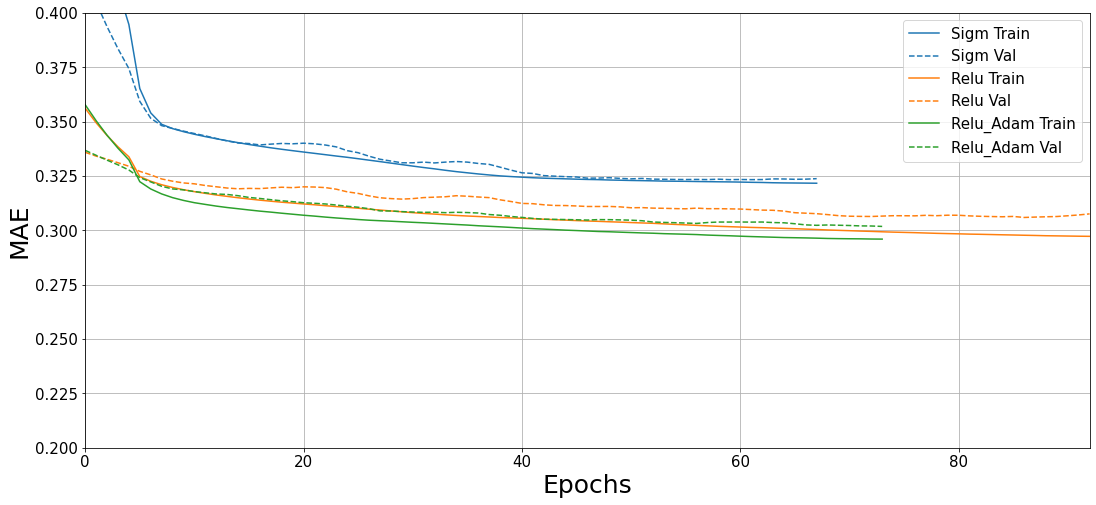

In [52]:
histories['ReLU_Adam'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.2, 0.40])
plt.ylabel('MAE')

In [53]:
nsize = 32
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.3013,  mae:0.3861,  mse:0.3013,  val_loss:0.1964,  val_mae:0.3331,  val_mse:0.1964,  
...........................................................................

Text(0, 0.5, 'MAE')

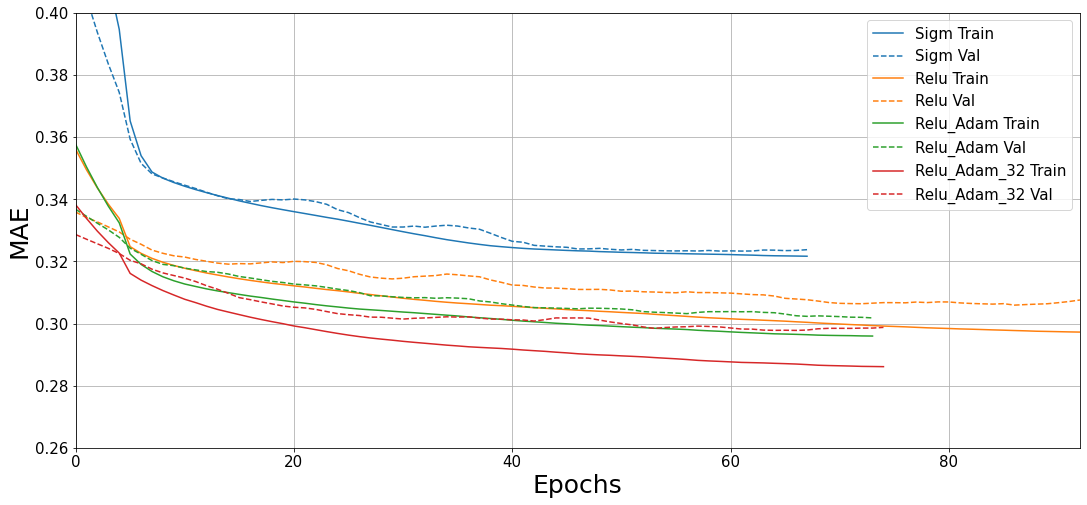

In [55]:
histories['ReLU_Adam_32'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.26, 0.40])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

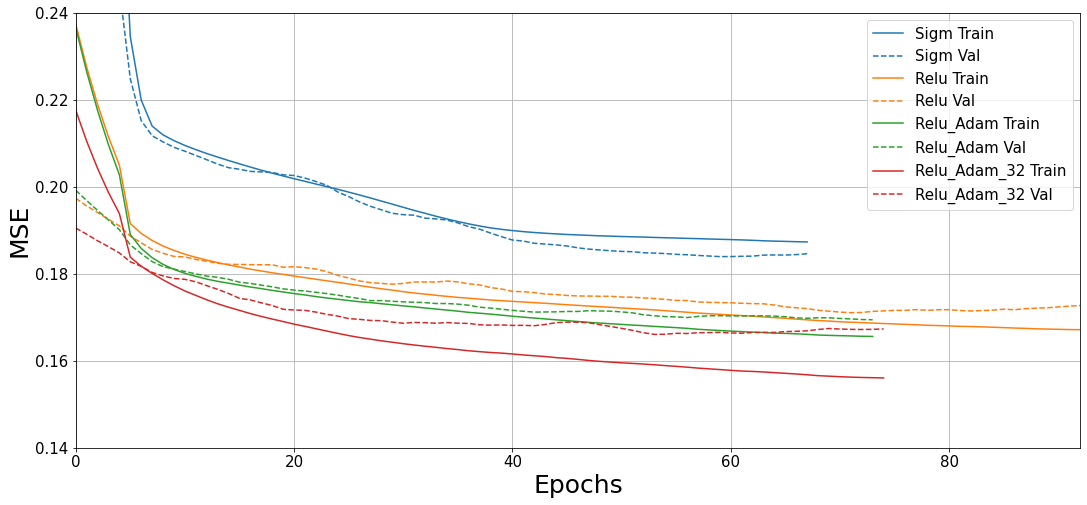

In [57]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.14, 0.24])
plt.ylabel('MSE')

In [58]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

2971/2971 - 0s - loss: 0.1867 - mae: 0.3253 - mse: 0.1867
Testing set for model 1, Mean Abs Error:    0.32530


In [59]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

2971/2971 - 0s - loss: 0.1738 - mae: 0.3088 - mse: 0.1738
Testing set for model 2, Mean Abs Error:              0.30875


In [60]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

2971/2971 - 0s - loss: 0.1730 - mae: 0.3065 - mse: 0.1730
Testing set for model 3, Mean Abs Error:              0.30654


In [61]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

2971/2971 - 0s - loss: 0.1679 - mae: 0.3021 - mse: 0.1679
Testing set for model 4, Mean Abs Error:              0.30207


In [62]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.32529792, 0.30875137, 0.30654168, 0.3020736]

In [63]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.18674187, 0.17375809, 0.1730153, 0.16787113]

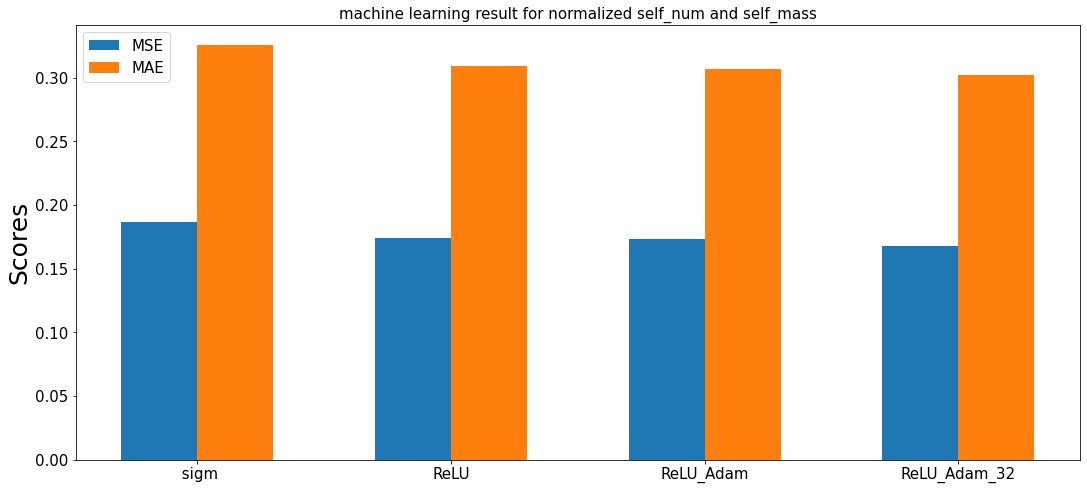

In [64]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [' sigm',
 'ReLU',
 'ReLU_Adam',
 'ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized self_num and self_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [65]:
test_true_self_num  = np.exp(test_labels.pop('self_num'))
test_true_self_mass = np.exp(test_labels.pop('self_mass'))

In [66]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [67]:
p1 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["self_num","self_mass","self_rmass","self_rvol"])

In [68]:
p1.describe()

self_num    self_mass   self_rmass    self_rvol
count  2971.000000  2971.000000  2971.000000  2971.000000
mean     -0.008797    -0.008476    -0.009394    -0.008642
std       0.936555     0.896204     0.862822     0.861651
min      -1.189677    -2.137959    -2.883978    -2.907266
25%      -0.683757    -0.634025    -0.665946    -0.657501
50%      -0.306037    -0.086787     0.033934     0.032799
75%       0.331441     0.494853     0.565162     0.561827
max       4.619637     3.702866     2.879078     2.929111

In [69]:
train_labels_stats

count       mean       std        min        25%        50%  \
self_num    13759.0   1.695976  1.458400   0.010881   0.587787   1.280934   
self_mass   13759.0 -17.018963  1.367236 -22.000086 -17.975079 -17.076052   
self_rmass  13759.0 -17.958218  1.779186 -26.742767 -19.097167 -17.831522   
self_rvol   13759.0 -23.173798  1.804852 -31.853756 -24.333010 -23.047249   

                  75%        max  
self_num     2.360854   8.169846  
self_mass  -16.160887 -11.872393  
self_rmass -16.745637 -12.505439  
self_rvol  -21.937400 -17.654455

In [70]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [71]:
test_predict1.describe()

self_num     self_mass    self_rmass     self_rvol
count  2971.000000  2.971000e+03  2.971000e+03  2.971000e+03
mean     34.787783  1.117248e-07  5.310753e-08  2.978729e-10
std     196.129713  3.543654e-07  1.495818e-07  8.732246e-10
min       0.961702  2.184110e-09  9.384725e-11  4.538623e-13
25%       2.011306  1.707204e-08  4.855969e-09  2.632534e-11
50%       3.489125  3.607661e-08  1.686807e-08  9.150754e-11
75%       8.840594  7.990867e-08  4.340510e-08  2.377545e-10
max    4597.449131  6.418852e-06  2.663684e-06  1.704881e-08

In [72]:
test_predict1_self_num  = test_predict1['self_num']
test_predict1_self_mass = test_predict1['self_mass']

In [73]:

p2 = pd.DataFrame(data=model4.predict(normed_test_data3), columns=["self_num","self_mass","self_rmass","self_rvol"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_self_num  = test_predict2['self_num']
test_predict2_self_mass  = test_predict2['self_mass']

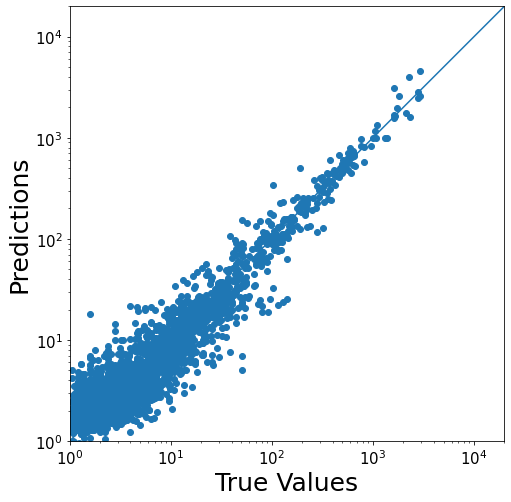

In [76]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e0, 2e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_num, test_predict1_self_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

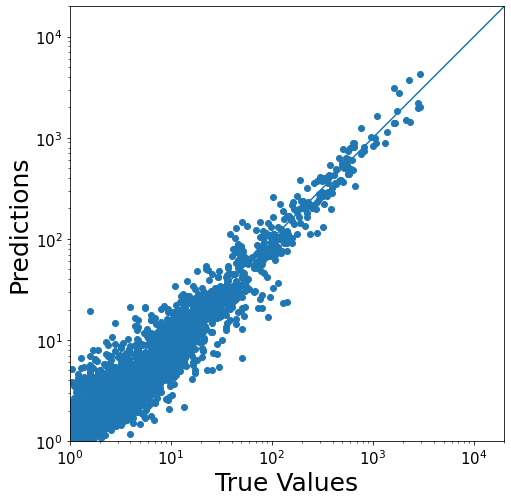

In [77]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_num, test_predict2_self_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

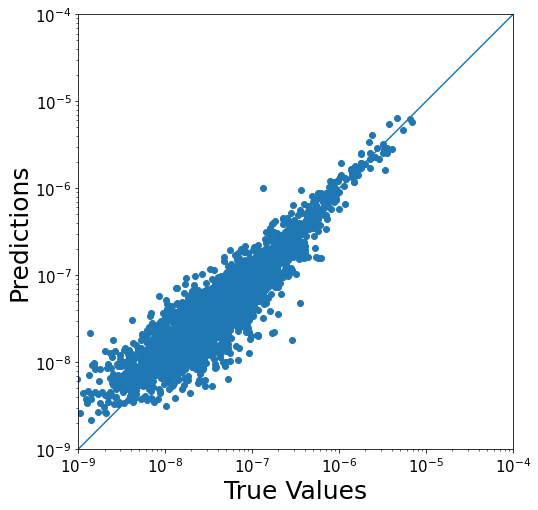

In [78]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-9, 1e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_mass, test_predict1_self_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

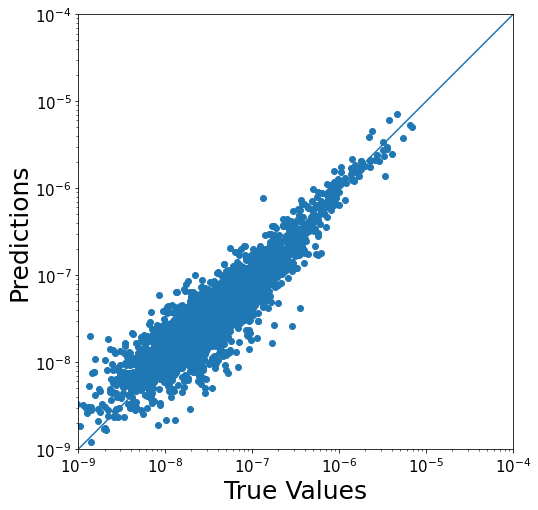

In [79]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_mass, test_predict2_self_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [80]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2

In [81]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [82]:
labels   = 'self_rimedice_num, self_rimedice_mass, self_rimedice_rmass, self_rimedice_rvol'
features = 'q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T, rho'
logtransform = np.array([True, True, True, True, False, False], dtype=bool)

filename = 'saved_model_v2/self_rimedice_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,filename)
filename = 'saved_model_v2/self_rimedice_model3_'+version+'.nc'
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)
filename = 'saved_model_v2/self_rimedice_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/self_rimedice_model2_08.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T, rho
  Labels:     self_rimedice_num, self_rimedice_mass, self_rimedice_rmass, self_rimedice_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 4), Activation: linear
Saving model to saved_model_v2/self_rimedice_model3_08.nc
  Features:   q_rimedice, n_rimedice, rmass_rimedice, rvol_rimedice, T, rho
  Labels:     self_rimedice_num, self_rimedice_mass, self_rimedice_rmass, self_rimedice_rvol
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (6, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
 